In [1]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [2]:
# Load Dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# View the size of train dataset
print(train_data.shape)

# View first 5 rows of train data
train_data.head()

(9557, 143)


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [3]:
# View the size of train dataset
print(test_data.shape)

# View first 5 rows of test data
test_data.head()

(23856, 142)


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


#### Identify the output variable:

In [4]:
# search for the column that is available in train data but unavailable in test data
target_variable = [col for col in train_data.columns if not col in test_data.columns]
target_variable

['Target']

In [5]:
train_data['Target'].unique()

array([4, 2, 3, 1], dtype=int64)

In [6]:
# view monthly rent payment for each level of poverty
train_data.groupby('Target')[['v2a1','rooms']].mean().round(2)

,v2a1,rooms
Target,,
1,84806.46,4.33
2,97015.17,4.48
3,102618.09,4.73
4,193589.26,5.21


- Noticed that the poverty level 1 pay the lowest average monthly rental, while level 4 pays the highest.
- We could derive from this analysis that poverty level is being the poorest segment, while level 4 being the least poorest segment from the dataset.

### Exploratory Data Analysis

#### Understand the type of data:

In [7]:
# check the types of data
train_data.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)

In [8]:
# find those columns with object data type
object_columns = [col for col in train_data.dtypes[train_data.dtypes == 'O'].index]
object_columns

['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa']

In [9]:
# find those columns with float data type
float_columns = [col for col in train_data.dtypes[train_data.dtypes == 'float64'].index]
float_columns

['v2a1',
 'v18q1',
 'rez_esc',
 'meaneduc',
 'overcrowding',
 'SQBovercrowding',
 'SQBdependency',
 'SQBmeaned']

In [10]:
# find those columns with integer data type
int_columns = [col for col in train_data.dtypes[train_data.dtypes == 'int64'].index]
print("The first 10 of {} columns with integer data types: \n".format(len(int_columns)),
                                                                     int_columns[:10])

The first 10 of 130 columns with integer data types: 
 ['hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'r4h1', 'r4h2', 'r4h3', 'r4m1']


#### Check if there are any biases in your dataset:

In [11]:
# check the distribution of target variable
train_data.groupby('Target').size()

Target
1     755
2    1597
3    1209
4    5996
dtype: int64

In [12]:
# present the distribution in proportional percentage
target_pct = train_data.groupby('Target').size().apply(lambda x: 100 * x / train_data['Target'].shape[0])
target_pct

Target
1     7.899969
2    16.710265
3    12.650413
4    62.739353
dtype: float64

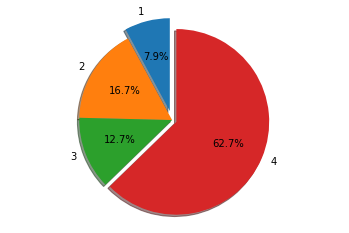

In [13]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
explode = (0.1, 0, 0, 0.05)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(target_pct.values, explode=explode, labels=target_pct.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

- Notice that 62.7% of the train dataset are from poverty level 4, which would lead the algorithm to learn from level 4 more than other levels. 
- The poorest poverty level, level 1, is ultimately our aim to predict, but it constitute only 7.9% of train dataset. This would lead to having our algorithm do a poor job in predictions.
- In other words, our predicting model might work well to identify poverty level 4 but not poverty level 1.

#### Check whether all members of the house have the same poverty level:

In [14]:
# check number of household 
train_data['idhogar'].nunique()

2988

In [15]:
# group individuals by their respective household
household_id = train_data[['idhogar','Target']].groupby(['idhogar'])

In [16]:
def check_positive(num):
    """
    This function check whether a number is positive.
    """
    if num > 0:
        return True
    else:
        return False

# find standard deviation of every household 
# id std == 0, then all members of the house have the same poverty level
household_level_std = household_id.std()

# note that std is non-negative
# let's find households that have positive std, which means there are variation of poverty level within household
unequal_poverty_household = household_level_std[household_level_std['Target'].apply(check_positive)]
unequal_poverty_household

,Target
idhogar,
0172ab1d9,0.547723
03f4e5f4d,0.577350
0511912b6,0.500000
078a0b6e2,0.577350
09e25d616,0.500000
...,...
e65d4b943,0.447214
efd3aec61,0.547723
f006348ed,0.547723


In [17]:
# view the first household with different-poverty-level members
household_id.get_group(unequal_poverty_household.index[0])

,idhogar,Target
7651,0172ab1d9,3
7652,0172ab1d9,2
7653,0172ab1d9,3
7654,0172ab1d9,3
7655,0172ab1d9,2


In [18]:
print("There are {} households having different-poverty-level members.".format(len(unequal_poverty_household)))

There are 85 households having different-poverty-level members.


#### Check if there is a house without a family head:

In [19]:
# if the sum of 'parentesco1' values in a household = 0, then the household has nobody a family head
household_head = train_data[['idhogar','parentesco1']].groupby('idhogar').sum()

In [20]:
# find the number of households without a family head
household_head.value_counts()

parentesco1
1              2973
0                15
dtype: int64

- There are 15 households without a family head.

#### Set poverty level of the members and the head of the house within a family:

In [21]:
# check if any households without a head has different-poverty-level members
house_no_head_id = household_head[household_head['parentesco1']==0].index
house_no_head_diff_poverty = [house in unequal_poverty_household.index for house in house_no_head_id] 
print("There are {} households without head have different-poverty-level members.".format(sum(house_no_head_diff_poverty)))

There are 0 households without head have different-poverty-level members.


- Since there is no household without head have different-poverty-level members, we may set all those households with different-poverty-level members to having all their own members the same poverty level as their household head.

In [22]:
for household in unequal_poverty_household.index:
    # Find household head's target
    head_target = train_data[(train_data['idhogar'] == household) & (train_data['parentesco1'] == 1)]['Target']
    
    # Set the household members' target as the same as their head
    train_data.loc[train_data['idhogar'] == household, 'Target'] = head_target
    
    
# check if still got any household with different-poverty-level members
new_household_std = train_data[['idhogar','Target']].groupby(['idhogar']).std()
new_unequal_poverty_household = new_household_std[new_household_std['Target'].apply(check_positive)]
print("Now there is {} households with different-poverty-level members.".format(len(new_unequal_poverty_household)))

Now there is 0 households with different-poverty-level members.


### Process Columns

#### Noted earlier that there are 3 non-id object-type columns 'dependency', 'edjefe', 'edjefa', let's understand these columns and fix them:

In [23]:
# view top 5 rows of these 3 variables
train_data[['dependency', 'edjefe', 'edjefa']].head()

,dependency,edjefe,edjefa
0,no,10,no
1,8,12,no
2,8,no,11
3,yes,11,no
4,yes,11,no


- Notice that there are a mixture of values.
- dependency: Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
- edjefe: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
- edjefa: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

In [24]:
mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [train_data, test_data]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype('float64')
    df['edjefa'] = df['edjefa'].replace(mapping).astype('int64')
    df['edjefe'] = df['edjefe'].replace(mapping).astype('int64')

train_data[['dependency', 'edjefa', 'edjefe']].dtypes

dependency    float64
edjefa          int64
edjefe          int64
dtype: object

In [25]:
train_data[['dependency', 'edjefe', 'edjefa']].isnull().sum()

dependency    0
edjefe        0
edjefa        0
dtype: int64

### Missing Values
#### Count how many null values are existing in columns:


In [26]:
pd.set_option('display.max_rows', None) # to view all rows

# find the number of null values for each column which has at least 1 null value
null_columns = train_data.isna().sum()
null_columns[null_columns>0]

v2a1         6860
v18q1        7342
rez_esc      7928
meaneduc        5
SQBmeaned       5
Target        250
dtype: int64

- Only columns 'rez_esc', 'v18q1', 'v2a1', 'Target', 'meaneduc', and 'SQBmeaned' have null values and each of them has 7928, 7342, 6860, 250,  5, and 5 null values respectively.

In [27]:
# Let's also check whether test datatset has the exact same columns with null values
null_test_columns = train_data.isna().any()
null_test_columns[null_test_columns]

v2a1         True
v18q1        True
rez_esc      True
meaneduc     True
SQBmeaned    True
Target       True
dtype: bool

#### Remove null value rows of the target variable:

In [28]:
# remove all rows whose target variable is null value
train_data = train_data[train_data['Target'].notna()]

In [29]:
# check target variable whether still has any null value
train_data['Target'].isna().any()

False

#### Fix null values in 'v2a1' column:
- v2a1: Monthly rent payment
- There are 6667 missing values

One main reason why it has missing values could be because the house is owned by the household. From data dictionary we find that:
- tipovivi1 =1 own and fully paid house
- tipovivi2 =1 own, paying in installments
- tipovivi3 =1 rented
- tipovivi4 =1 precarious
- tipovivi5 =1 other(assigned, borrowed)

In [30]:
# let's count how many rows are those who own a house so they don't have rental payment
no_rent1 = train_data['tipovivi1'].sum()
no_rent2 = train_data['tipovivi2'].sum()

print("In total there are {} households don't need to pay rental.".format(no_rent1+no_rent2))

In total there are 6709 households don't need to pay rental.


In [31]:
# Hence, it makes sense that we fill the null values of v2a1 with 0
for df in [train_data, test_data]:
    df['v2a1'].fillna(0, inplace=True)

# check 'v2a1' whether still has any null value
train_data['v2a1'].isna().any()

False

#### Fix null values in 'v18q1' column:
- v18q1: number of tablets household owns
- There are 7114 missing values
- From data dictionary noticed that v18q (owns a tablet) is related variable and it has no null value

In [32]:
# let's find the total number of individual who doesn't have any table
no_tablet = len(train_data) - train_data['v18q'].sum()
no_tablet

7114

- There are exactly 7114 individuals do not own a tablet. 
- Hence it would make sense for us to conclude that, the missing values are because when none of their family members own a table, then they never provide the data of how many tablets the household own, so it should be zero, otherwise 'v18q1' columb should have more than 7114 missing values if there was any households who own at least 1 tablet never provide the data.

In [33]:
# Hence, it makes sense that we fill the null values of v18q1 with 0
for df in [train_data, test_data]:
    df['v18q1'].fillna(0, inplace=True)

# check 'v18q1' whether still has any null value
train_data['v18q1'].isna().any()

False

#### Fix null values in 'rez_esc' column:
- rez_esc: Years behind in school
- There are 7788 missing values
- From data dictionary noticed that v18q (owns a tablet) is related variable and it has no null value

In [34]:
# first, let's check the range of years behind in school
years_behind = train_data['rez_esc'][train_data['rez_esc'].notnull()]
years_behind.unique()

array([1., 0., 3., 2., 4., 5.])

- From the analysis above we know that that those who aren't behind the school (at value 0.0) are also recorded.
- Years behind in school could imply the poverty seriousness of the household that affect their children's study.
- Hence, it might not be advisable to drop this column with meaningful insight.
- While there could be a student who is in the midst of schoooling but never provide the data, the majority of missing values could be because they are working adult (thus not in school), too young to enter school yet, during schooling age but not in schooling, etc.
- One approach we can adopt is to identify individuals within the schooling age and has missing value on 'rez_esc' column, impute it with median value, while other missing values for those not within schooling age we set them to zero.

In [35]:
# view the overall statistic of 'age' column
train_data['age'].describe()

count    9307.000000
mean       34.651445
std        21.630574
min         0.000000
25%        17.000000
50%        32.000000
75%        51.000000
max        97.000000
Name: age, dtype: float64

- The age of individuals from entire train dataset ranges from 0 to 97 years old.

In [36]:
# Now, check the age of individual for those with non-null values under 'rez_esc' column
train_data['age'][train_data['rez_esc'].notnull()].describe()

count    1519.000000
mean       12.216590
std         3.197469
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

- sighted that the schooling age should be ranging from 7 to 17 years old.

In [37]:
null_behind_school = train_data[['rez_esc','age']][train_data['rez_esc'].isnull()]
null_school_7_17 = null_behind_school[(null_behind_school['age'] >= 7) & (null_behind_school['age'] <= 17)]
null_school_others = null_behind_school.drop(null_school_7_17.index, axis=0)

In [38]:
# fill the null values of rez_esc with age 7 to 17 with median value of the same age group
# fill the null values of other individuals in rez_esc column with 0
for df in [train_data, test_data]:
    df.loc[null_school_7_17.index,'rez_esc'] = years_behind.median()
    df.loc[null_school_others.index,'rez_esc'] = 0

# check 'rez_esc' whether still has any null value
train_data['rez_esc'].isna().any()

False

#### Fix null values in 'meaneduc' & 'SQBmeaned' columns:
- meaneduc: average years of education for adults (18+)
- SQBmeaned:square of the mean years of education of adults (>=18) in the household
- There are 5 missing values in each of the two columns above
- These two coloumns are related

In [39]:
# let's confirm that the 5 missing values are from the same rows of both coloumns
# compare with relevant columns:
# escolari: years of schooling
# instlevel1 =1 no level of education

education_col = ['idhogar', 'meaneduc', 'SQBmeaned', 'age','escolari']

train_data[education_col][train_data['meaneduc'].isnull()]

,idhogar,meaneduc,SQBmeaned,age,escolari
1291,1b31fd159,NaN,NaN,18,10
1840,a874b7ce7,NaN,NaN,18,6
1841,a874b7ce7,NaN,NaN,18,4
2049,faaebf71a,NaN,NaN,19,12
2050,faaebf71a,NaN,NaN,19,12


- Since the age of all these 5 individuals are 18+, we can impute the missing values with the mean of 'meaneduc'
- The same logic applies to SQBmeaned column as well

In [40]:
meaneduc_avg = train_data['meaneduc'][train_data['age'] >=18].mean()
SQBmeaned_avg = train_data['SQBmeaned'][train_data['age'] >=18].mean()

# impute the null values of 'meaneduc' with its average 
# impute the null values of 'SQBmeaned' with the square of the mean years of education of adults (>=18) in the household
for df in [train_data, test_data]:
    meaneduc_avg = df['meaneduc'][df['age'] >=18].mean()
    df['meaneduc'].fillna(meaneduc_avg, inplace=True)
    
    SQBmeaned_avg = np.square(df[['idhogar','escolari']][df['age'] >=18].groupby('idhogar').mean())
    null_household_id = df['idhogar'][df['SQBmeaned'].isnull()].values
    for house in null_household_id:
        try:
            df['SQBmeaned'][df['idhogar']==house] = SQBmeaned_avg.loc[house].values
        except: # capture those household with nobody at 18+ years old
            df['SQBmeaned'][df['idhogar']==house] = np.square(df['escolari'][df['idhogar']==house].mean())

# check whether 'meaneduc' & 'SQBmeaned' still has any null value
print("Column 'meaneduc' in train dataset has {} null values.".format(train_data['meaneduc'].isna().sum()))
print("Column 'SQBmeaned' in train dataset has {} null values.".format(train_data['SQBmeaned'].isna().sum()))

Column 'meaneduc' in train dataset has 0 null values.
Column 'SQBmeaned' in train dataset has 0 null values.


### Model Building

#### Predict the accuracy using random forest classifier:

In [41]:
X_features = train_data.drop(['Id', 'idhogar','Target'], axis=1)
y_target = train_data['Target']

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features , y_target, test_size=0.3, random_state=42)

In [43]:
rfc1=RandomForestClassifier(n_jobs=-1,random_state=51)
rfc1.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1, random_state=51)

In [44]:
y_pred = rfc1.predict(X_test)

In [45]:
print(accuracy_score(y_test,y_pred))

0.9180093089867526


#### Check the accuracy using random forest with cross validation:

In [46]:
X_train = train_data.drop(['Id', 'idhogar','Target'], axis=1)
y_train = train_data['Target']

In [47]:
kfold = KFold(n_splits=10,shuffle=True,random_state=7)
score = cross_val_score(rfc1,X_train,y_train,cv=kfold,n_jobs=-1,scoring='accuracy')
print(score.mean())

0.9459555570955036
